# Condition by Novelty-Metric

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import numpy as np

## Use Objective Wrapper
- to minimize different `foo`s
- or `maximize` them.
- In the latter case, we may need to specify numerical limits to constraint the search-space

### Implement `NoveltyCondition` Class
- a condition should be derived from `condevo.es.Condition`.
- In the `evaluate` method, we evaluate the novelty score based on a nearest neighbor metric to all samples in the buffer.
- In the `sample`, we sample conditions with large novelty scores from a Boltzmann distribution, and we apply noise to the condition samples.
- The condition instances is then passed in a tuple of conditions to the `condevo.es.CHARLES` constructor.
- In the `benchmark.run` wrapper, we also apply JSON dumps for the `condevo.es.CHARLES` kwargs, thus a `to_dict` method is implemented.

In [3]:
from condevo.es.guidance import Condition, KNNNoveltyCondition, FitnessCondition
from benchmark import utils, configs, run

### Perform `"CHARLES"` optimization with the `benchmark.run` Wrapper
- different `es` implementations might be used, and configured via the `es_config` dictionary parameter
- different `diff` diffusion models (DMs) might be used (below we use `"RectFlow"`. Again, the DM can be configured with a `diff_config` dictionary (default configs are located in the `configs` module for all available `diff` DMs.)
- different `nn` neural networks might be used, and configured with the `nn_config` dictionary.
- a destination path `dst` for the output `hdf5` files (logging population parameters, fitness and model loss for every generation for every separate evolutionary run) might be specified, but defaults to `utils.DST`. The `hdf5` files follow a naming scheme defined by `utils.H5_FILE`.
- the evaluation can be turned `quiet`
- see documentation of `run` for more info

/home/bene/anaconda3/envs/mcr/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


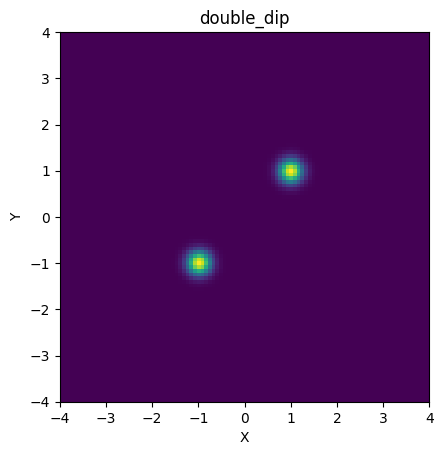

In [4]:
from foobench import Objective
from foobench.plot import visualize_2D

o = Objective(foo="double_dip", maximize=True)
visualize_2D(o)

In [5]:
DST = utils.DST + '/paper_HADES/experiment_novelty'


def get_objective(objective):
    if objective == "double_dip":
        return Objective(foo="double_dip", maximize=True, foo_kwargs=dict(m=1.0))

    if objective == "himmelblau":
        return Objective(foo="himmelblau", maximize=True, limits=5, apply_limits=True, limit_val=100)

    if objective == "rastrigin":
        return Objective(foo="rastrigin", maximize=False, limits=4, apply_limits=True, limit_val=0)

    raise NotImplementedError(objective)

def run_experiments(conditions, dst, niter=2, objective="double_dip"):
    es_config = {**configs.CHARLES, "conditions": conditions}
    es_config["selection_pressure"] = 5.
    es_config["adaptive_selection_pressure"] = True
    es_config["elite_ratio"] = 0.25
    es_config["crossover_ratio"] = 0.0
    es_config["mutation_rate"] = 0.0
    es_config["readaptation"] = False
    es_config["forget_best"] = True
    es_config["diff_lr"] = 3e-3
    es_config["diff_max_epoch"] = 100
    es_config["buffer_size"] = 4
    es_config["sigma_init"] = 0.1


    kwargs = dict(
        objective=get_objective(objective),
        generations=41,
        diff="DDIM",
        nn="MLP",
        # utilize novelty conditioning:
        es="CHARLES",
        es_config=es_config,
    )
    return [run(nn_config={"num_conditions": len(conditions), **configs.MLP}, dst=dst, **kwargs) for _ in range(niter)]


## Path-Config

In [6]:
DST_baseline = DST + "/baseline"
DST_fisher = DST + "/charles_fisher"
DST_greedy = DST + "/charles_greedy"
DST_novelty = DST + "/novelty_128"
DST_novelty_fisher = DST + "/novelty_128-charles_fisher"
DST_novelty_greedy = DST + "/novelty_128-charles_greedy"

In [7]:
# The follwoing is timeconsuming, consider going parallel, 
# You might you might contact the authors to get the data directly (~1GB)
EXECUTE_RUNS = False 
if EXECUTE_RUNS:
    rc = run_experiments(conditions=(), dst=DST_baseline)
    rc_fisher = run_experiments(conditions=(FitnessCondition(greedy=False),), dst=DST_fisher)
    rc_greedy = run_experiments(conditions=(FitnessCondition(greedy=True),), dst=DST_greedy)
    rc_novelty = run_experiments(conditions=(KNNNoveltyCondition(k=128, weight_by_fitness=True),), dst=DST_novelty)
    rc_novelty_fisher = run_experiments(conditions=(KNNNoveltyCondition(k=128, weight_by_fitness=True), FitnessCondition()), dst=DST_novelty_fisher)
    rc_novelty_greedy = run_experiments(conditions=(KNNNoveltyCondition(k=128, weight_by_fitness=True), FitnessCondition(greedy=True)), dst=DST_novelty_greedy)

In [13]:
from analysis import load_benchmark

df_baseline = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_baseline)
df_cma = load_benchmark(objective="double_dip", es="CMAES", dst=DST_baseline)
df_simplega = load_benchmark(objective="double_dip", es="SimpleGA", dst=DST_baseline)
df_fisher = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_fisher)
df_greedy = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_greedy)
df_novelty = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_novelty)
df_novelty_fisher = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_novelty_fisher)
df_novelty_greedy = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_novelty_greedy)

loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/baseline/ES_CHARLES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/baseline/ES_CMAES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/baseline/ES_SimpleGA-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/charles_fisher/ES_CHARLES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/charles_greedy/ES_CHARLES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/novelty_128/ES_CHARLES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/novelty_128-charles_fisher/ES_CHARLES-objective_double_dip.h5
loading data from data/es_benchmark/optimize/paper_HADES/experiment_novelty/novelty_128-charles_greedy/ES_CHARLES-objective_doub

In [14]:
import numpy as np
from scipy.stats import entropy

def evaluate_entropy_on_grid(x, nx, lx, ny=None, ly=None):
    """
    Discretizes 2D points in x (batch, 2) into a grid of size (nx, ny)
    and evaluates the entropy over the grid cells.
    
    Args:
        x (numpy.ndarray): Input array of shape (batch, 2), representing 2D points.
        nx (int): Number of grid cells in the x-direction.
        ny (int): Number of grid cells in the y-direction.
        lx (float): Length of the grid in the x-direction.
        ly (float): Length of the grid in the y-direction.
    
    Returns:
        float: Entropy value over the grid.
    """
    batch_size, _ = x.shape
    ny, ly = ny or nx, ly or lx

    # Create the grid cell size in both directions
    cell_size_x = lx / nx
    cell_size_y = ly / ny

    # Shift the points to the positive range (e.g., if grid is centered at 0)
    x_shifted = x + np.abs(x.min(axis=0))

    # Discretize the points into grid cells (vectorized)
    i = np.clip((x_shifted[:, 0] / cell_size_x).astype(int), 0, nx - 1)  # X grid indices
    j = np.clip((x_shifted[:, 1] / cell_size_y).astype(int), 0, ny - 1)  # Y grid indices

    # Use np.bincount to count occurrences of points in each grid cell
    grid_counts = np.bincount(i * ny + j, minlength=nx * ny)  # Flattened 2D grid to 1D

    # Reshape back to (nx, ny) and normalize to form a probability distribution
    grid_prob = grid_counts.reshape(nx, ny) / np.sum(grid_counts)

    # Flatten the grid and compute the entropy
    grid_prob_flat = grid_prob.flatten()

    # Compute entropy using Shannon's entropy formula (with small constant to avoid log(0))
    return entropy(grid_prob_flat + 1e-10, base=np.e)

(-3.0, 3.0)

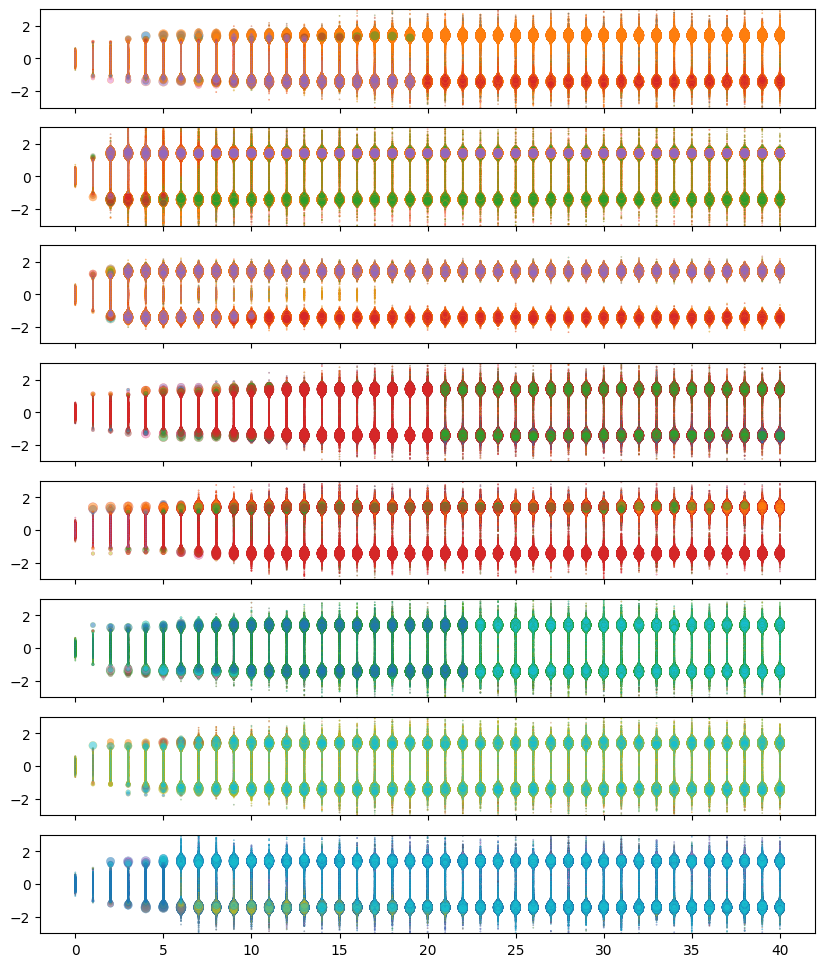

In [25]:
fig, axes = plt.subplots(8, 1, sharex=True, sharey=True, figsize=(10, 12))

def get_data(df, ax, color="tab:blue"):
    p = np.array((1., 1.))
    p = p[:] / np.linalg.norm(p)
    
    d_best = []
    d_mu = []
    d_std = []
    d_fit = []    
    d_gens = []
    d_entropy = []
    d_final = []
    d_q3 = []
    d_q1 = []
    for r, df_r in df.groupby("run"):
        df_r = df_r.sort_values("gen")
        d_r = np.array([s.dot(p) for s in df_r["samples"]])    
        d_q3i = np.array([s - (-1, -1) for s in df_r["samples"]])    
        d_q1i = np.array([s - (+1, +1) for s in df_r["samples"]])    
        d_f = np.array([f for f in df_r["fitness"]])
        d_fbest = d_f.argmax(axis=1)
        d_best.append([d_ri[b] for d_ri, b in zip(d_r, d_fbest)])    
        g_r = np.array([[gi] * d_r.shape[1] for gi in df_r["gen"]])       
        d_mu.append(d_r.mean(axis=1))
        d_std.append(d_r.std(axis=1))
        d_entropy.append([evaluate_entropy_on_grid(d_ri, nx=256, lx=16) for d_ri in df_r["samples"]])
        d_fit.append(d_f)
        d_gens.append(g_r)

        ax.scatter(g_r.flatten(), d_r.flatten(), s=50 * d_f.flatten() + 1, alpha=0.5, marker="o", edgecolors=color, linewidth=0.25)
        d_final.append(df_r["samples"].values[-2])
        d_q3.append(np.linalg.norm(d_q3i, axis=-1))
        d_q1.append(np.linalg.norm(d_q1i, axis=-1))

    return {"best": d_best, "mu": d_mu, "std": d_std, "gens": d_gens, "entropy": d_entropy, "fitness": d_fit, "final": d_final, "dq1": d_q1, "dq3": d_q3}

#p1_best, p1_mu, p1_std, p1_gens = get_data(df_baseline, color="tab:red", ax=ax1)
data_baseline = get_data(df_baseline, color="tab:orange", ax=axes[0])
data_cma = get_data(df_cma, color="tab:orange", ax=axes[1])
data_simplega = get_data(df_simplega, color="tab:orange", ax=axes[2])
data_fisher = get_data(df_fisher, color="tab:red", ax=axes[3])
data_greedy = get_data(df_greedy, color="tab:red", ax=axes[4])
data_novelty = get_data(df_novelty, color="tab:green", ax=axes[5])
data_novelty_fisher = get_data(df_novelty_fisher, color="tab:olive", ax=axes[6])
data_novelty_greedy = get_data(df_novelty_greedy, color="tab:blue", ax=axes[7])

axes[0].set_ylim([-3, 3])

In [16]:
dl = [1, 2, 3]
dl.pop(2)
dl

[1, 2]

In [32]:
for data in (data_baseline, data_fisher, data_greedy, data_novelty, data_novelty_fisher, data_novelty_greedy, data_cma, data_simplega):
    shape_0 = np.shape(data["entropy"][0])[0]
    to_del = []
    for i in range(len(data["entropy"])):
        if np.shape(data["entropy"][i])[0] != shape_0:
            to_del.append(i)
    
    for v in data.values():
        for i in to_del:
            v.pop(i)

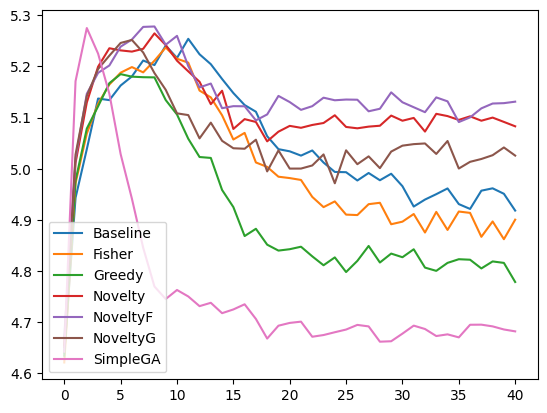

In [18]:
plt.plot(np.mean(data_baseline["entropy"], axis=0), label="Baseline")
plt.plot(np.mean(data_fisher["entropy"], axis=0), label="Fisher")
plt.plot(np.mean(data_greedy["entropy"], axis=0), label="Greedy")
plt.plot(np.mean(data_novelty["entropy"], axis=0), label="Novelty")
plt.plot(np.mean(data_novelty_fisher["entropy"], axis=0), label="NoveltyF")
plt.plot(np.mean(data_novelty_greedy["entropy"], axis=0), label="NoveltyG")
#plt.plot(np.mean(data_cma["entropy"], axis=0), label="CMA")
plt.plot(np.mean(data_simplega["entropy"], axis=0), label="SimpleGA")
plt.legend()

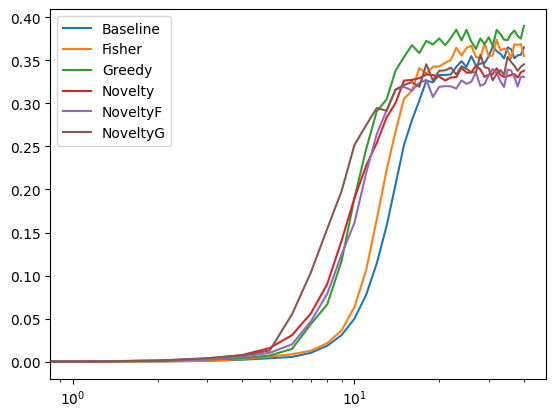

In [19]:
plt.plot(np.mean(np.mean(data_baseline["fitness"], axis=-1), axis=0), label="Baseline")
plt.plot(np.mean(np.mean(data_fisher["fitness"], axis=-1), axis=0), label="Fisher")
plt.plot(np.mean(np.mean(data_greedy["fitness"], axis=-1), axis=0), label="Greedy")
plt.plot(np.mean(np.mean(data_novelty["fitness"], axis=-1), axis=0), label="Novelty")
plt.plot(np.mean(np.mean(data_novelty_fisher["fitness"], axis=-1), axis=0), label="NoveltyF")
plt.plot(np.mean(np.mean(data_novelty_greedy["fitness"], axis=-1), axis=0), label="NoveltyG")
plt.semilogx()
plt.legend()

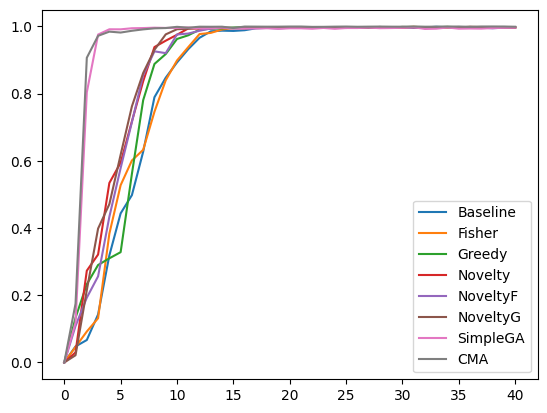

In [20]:
dataset = ((data_baseline, "Baseline"),
           (data_fisher, "Fisher"),
           (data_greedy, "Greedy"), 
           (data_novelty, "Novelty"), 
           (data_novelty_fisher, "NoveltyF"), 
           (data_novelty_greedy, "NoveltyG"), 
           (data_simplega, "SimpleGA"),
           (data_cma, "CMA"), 
         )

key = "fitness"
foo = np.max

for data, label in dataset:
    gens = data["gens"][0][:, 0]
    y_raw = foo(data[key], axis=-1)
    y_show = np.mean(y_raw, axis=0)
    plt.plot(gens, y_show, label=label)    
    
    #y_raw = np.mean(data[key], axis=-1)
    #y_show = np.mean(y_raw, axis=0)
    #plt.plot(gens, y_show, label=label)
    #plt.fill_between(gens, y_show - np.std(y_raw, axis=0), np.max(y_raw, axis=0), alpha=0.2)

plt.legend()
#plt.semilogx()

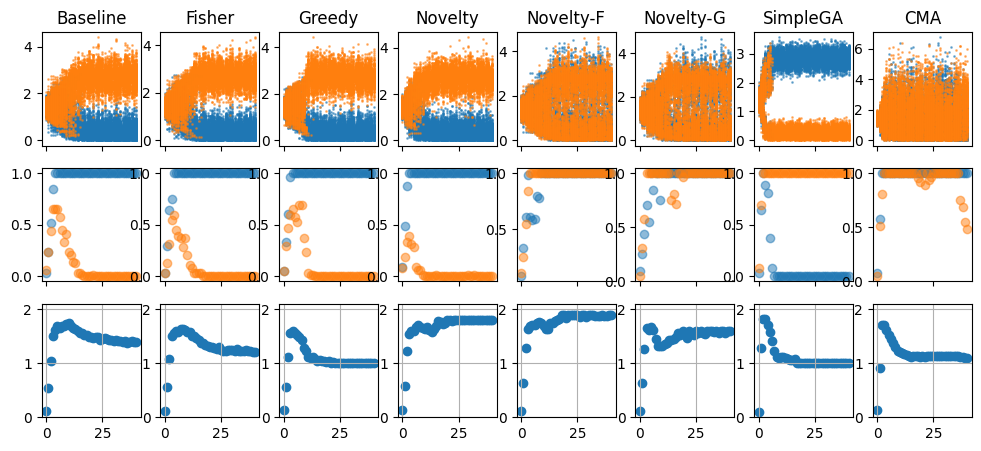

In [116]:
run_id = 5

fig, axes = plt.subplots(3, len(dataset), figsize=(12, 5), sharex=True)
for i, (data, ax_rows) in enumerate(zip(dataset, axes.T)):
    df, label = data
    g = df["gens"][run_id]
    dq3 = df["dq3"][run_id]
    dq1 = df["dq1"][run_id]

    ax_rows[0].set_title(label)
    ax_rows[0].scatter(g.flatten(), dq3.flatten(), alpha=0.5, s=1)
    ax_rows[0].scatter(g.flatten(), dq1.flatten(), alpha=0.5, s=1)

    dp = 1.  # np.linalg.norm((1, 1))
    ax_rows[1].scatter(g[:, 0], np.mean(np.sort(dq3 < dp)[:, -64:], axis=-1), alpha=0.5)
    ax_rows[1].scatter(g[:, 0], np.mean(np.sort(dq1 < dp)[:, -64:], axis=-1), alpha=0.5)
    
    num_targets = []
    g = df["gens"][run_id]
    dq3 = df["dq3"][run_id]
    dq1 = df["dq1"][run_id]
    for g, dq3, dq1 in zip(df["gens"], df["dq3"], df["dq1"]):
        dq1_found = np.mean(np.sort(dq1 < dp)[:, -64:], axis=-1)
        dq3_found = np.mean(np.sort(dq3 < dp)[:, -64:], axis=-1)
        num_targets.append(dq1_found + dq3_found)
    
    ax_rows[2].scatter(g[:, 0], np.mean(num_targets, axis=0))
    ax_rows[2].set_ylim([0, 2.1])
    ax_rows[2].grid()
    

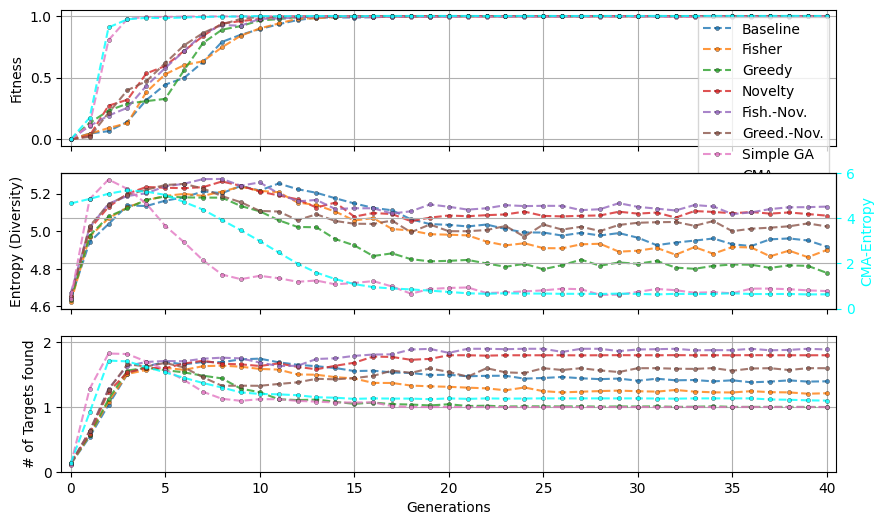

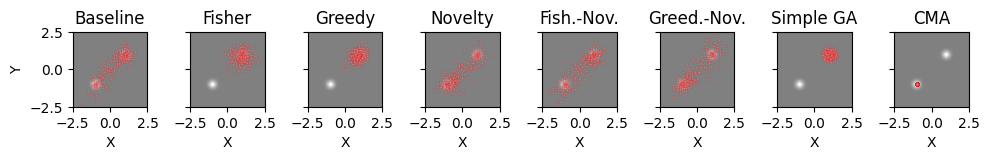

In [134]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
ax1.set_ylabel("Fitness")
ax2.set_ylabel("Entropy (Diversity)")
ax3.set_ylabel("# of Targets found")
ax3.set_xlabel("Generations")

dataset = ((data_baseline, "Baseline"),
           (data_fisher, "Fisher"),
           (data_greedy, "Greedy"), 
           (data_novelty, "Novelty"), 
           (data_novelty_fisher, "Fish.-Nov."), 
           (data_novelty_greedy, "Greed.-Nov."), 
           (data_simplega, "Simple GA"),
           (data_cma, "CMA"), 
         )

f1, axes = plt.subplots(1, len(dataset), figsize=(10, 2), sharex=True, sharey=True)

for i, (data, label) in enumerate(dataset):
    gens = data["gens"][0][:, 0]
    y_raw = np.max(data["fitness"], axis=-1)
    y_show = np.mean(y_raw, axis=0)
    ax1.plot(gens, y_show, label=label, color="cyan" if label == "CMA" else None, marker=".", linestyle="--", alpha=0.8, markeredgecolor="black", markeredgewidth=0.25)
    
    y_show = np.mean(data["entropy"], axis=0)

    color = None
    if label == "CMA":
        ax2 = ax2.twinx()
        color = "cyan"
        ax2.set_ylabel("CMA-Entropy")
        ax2.set_ylim([0, 6])        
        ax2.tick_params(axis='y', colors=color)
        ax2.yaxis.label.set_color(color)
        
    ax2.plot(gens, y_show, label=label, color=color, marker=".", linestyle="--", alpha=0.8, markeredgecolor="black", markeredgewidth=0.25)
    
    fraction = 64
    num_targets = []
    for g, dq3, dq1 in zip(data["gens"], data["dq3"], data["dq1"]):
        dq1_found = np.mean(np.sort(dq1 < dp)[:, -fraction:], axis=-1)
        dq3_found = np.mean(np.sort(dq3 < dp)[:, -fraction:], axis=-1)
        num_targets.append(dq1_found + dq3_found)
    
    ax3.plot(g[:, 0], np.mean(num_targets, axis=0), color=color, marker=".", linestyle="--", alpha=0.8, markeredgecolor="black", markeredgewidth=0.25)
    ax3.set_ylim([0, 2.1])

    axes[i].scatter(*data["final"][0].T, s=2, color="white", alpha=0.2, edgecolors="tab:red")
    visualize_2D(Objective(foo="double_dip", maximize=True, foo_kwargs=dict(m=1.0)), cmap="binary_r", ax=axes[i], vmin=-1, vmax=1, title=label),
    axes[i].set_xlim([-2.5, 2.5])
    axes[i].set_ylim([-2.5, 2.5])
    if i != 0:
        axes[i].set_ylabel("")
    
    #y_raw = np.mean(data[key], axis=-1)
    #y_show = np.mean(y_raw, axis=0)
    #plt.plot(gens, y_show, label=label)
    #plt.fill_between(gens, y_show - np.std(y_raw, axis=0), np.max(y_raw, axis=0), alpha=0.2)

[ax.grid() for ax in (ax1, ax2, ax3)]
ax1.legend()
ax1.set_xlim([-0.5, 40.5])
f1.tight_layout()

f1.savefig("novelty_solutions.png", dpi=300)
f.savefig("novelty_diversity_fitness.pdf")
#plt.semilogx()

In [ ]:
fig, axes = plt.subplots(2, len(dataset), figsize=(12, 5))
for i, (data, ax_rows) in enumerate(zip(dataset, axes.T)):    
    df, label = data
    num_targets = []
    for g, dq3, dy1 in zip(df["gens"], df["dq3"], df["dq1"]):
        dq1_found = np.mean(np.sort(dq3 < dp)[:, -64:], axis=-1)
        dq3_found = np.mean(np.sort(dq3 < dp)[:, -64:], axis=-1)
        num_targets.append(dq1_found + dq3_found)
    
    

    ax_rows[0].set_title(label)
    ax_rows[0].scatter(g.flatten(), dq3.flatten(), alpha=0.5, s=1)
    ax_rows[0].scatter(g.flatten(), dq1.flatten(), alpha=0.5, s=1)

    dp = 1.  # np.linalg.norm((1, 1))
    ax_rows[1].scatter(g[:, 0], , alpha=0.5)
    ax_rows[1].scatter(g[:, 0], np.mean(np.sort(dq1 < dp)[:, -64:], axis=-1), alpha=0.5)
    

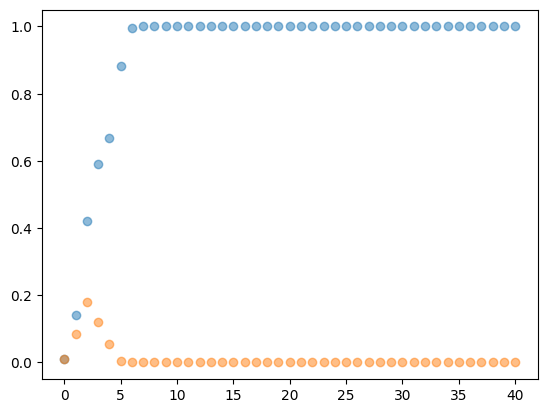

In [73]:
plt.scatter(g[:, 0], np.mean(dq3 < 1., axis=-1), alpha=0.5)
plt.scatter(g[:, 0], np.mean(dq1 < 1., axis=-1), alpha=0.5)